In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from flask import Flask

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB so we can query the database
session = Session(engine)

# Explore the Databases

In [23]:
from sqlalchemy import inspect

## Create the inspector and connect it to the engine
inspector = inspect(engine)

## Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [24]:
# Using the inspector to print the column names within the 'Station' table and its types
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [25]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# 1) Calculate the date 1 year ago from the last data point in the database
# 2) Perform a query to retrieve the data and precipitation scores
# 3) Save the query results as a Pandas DataFrame and set the index to the date column
# 4) Sort the dataframe by date
# 5) Use Pandas Plotting with Matplotlib to plot the data


In [27]:
## Explore the Measurement data
## a. Total No. of dates: 
totalNumDates = session.query(func.count(Measurement.date)).all()
earliestDate = session.query(Measurement.date).order_by(Measurement.date).first()

## Get the most recent date in Measurement
mostRecentDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(f"totalNumDates = {totalNumDates[0]}, earliestDate = {earliestDate[0]}, mostRecentDate = {mostRecentDate[0]}")

totalNumDates = (19550,), earliestDate = 2010-01-01, mostRecentDate = 2017-08-23


In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# 1) Calculate the date 1 year ago from the last data point in the database
mostRecentDate_obj = dt.datetime.strptime(mostRecentDate[0], '%Y-%m-%d')
# sqlQueryDate = mostRecentDate_obj - dt.timedelta(days=365)
sqlQueryDate = dt.date(mostRecentDate_obj.year - 1, mostRecentDate_obj.month, mostRecentDate_obj.day)
sqlQueryDate

datetime.date(2016, 8, 23)

In [29]:
# 2) Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
date_precipitation_resultset = session.query(*sel).filter(Measurement.date >= sqlQueryDate).all()

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# 3) Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(date_precipitation_resultset, columns = ['Date', 'Precipitation'])

## remove na values if any
precipitation_df.dropna(how='any', inplace=True)
precipitation_df.set_index('Date', inplace=True)

## 4) Sort the dataframe by date, and then set the date as index
precipitation_df = precipitation_df.sort_index(ascending=True)
#sorted_precipitation_df = precipitation_df.set_index('Date')
# precipitation_df_sorted = precipitation_df_sorted.set_index('Date')

precipitation_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


In [31]:
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


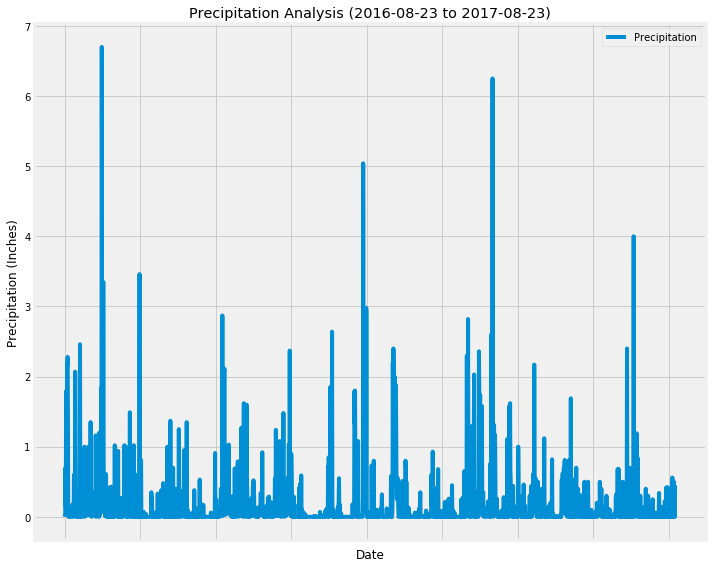

In [33]:
# 5) Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10,8))
# sorted_precipitation_df.plot('Date', 'Precipitation')
plt.title(f"Precipitation Analysis ({sqlQueryDate} to {mostRecentDate[0]})")
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks(rotation = 90)

## Save the image: 
plt.savefig("Images/My_Precipitation_Analysis.png")

plt.tight_layout()
plt.show()

In [34]:
# Design a query to show how many stations are available in this dataset?
totalNumStations_lst = session.query(Station.id).count()
totalNumStations_lst

9

In [35]:
# totalNumStations_lst = session.query(func.count(Measurement.station)).all()
# totalNumStations

In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.station)]
activeStations_lst = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(activeStations_lst)

## The first element is the most active station with the highest number of measures.
mostActiveStation = activeStations_lst[0][0]
print(f"\nThe Most active station: {mostActiveStation}")


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]

The Most active station: USC00519281


In [37]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)
      ]

temp_averages = session.query(*sel).filter(Measurement.station == mostActiveStation).all()

temp_averages[0]

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [38]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
## Use the above station: 
stationWithHighestNoTempObser = temp_averages[0][0]
temp_data_lst = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == stationWithHighestNoTempObser).\
    filter(Measurement.date > sqlQueryDate).all()

print(f"length of temp_data_lst: {str(len(temp_data_lst))}")
# temp_data_lst

length of temp_data_lst: 351


In [39]:
temp_df = pd.DataFrame(temp_data_lst)
temp_df

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0
5,USC00519281,2016-08-29,78.0
6,USC00519281,2016-08-30,77.0
7,USC00519281,2016-08-31,78.0
8,USC00519281,2016-09-01,80.0
9,USC00519281,2016-09-02,80.0


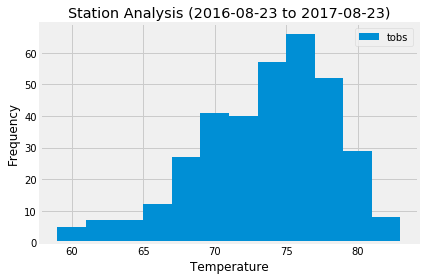

In [40]:
# Plot the results as a histogram with bins=12.
temp_df.plot.hist(bins = 12)
plt.title(f"Station Analysis ({sqlQueryDate} to {mostRecentDate[0]})")
# plt.title(f"Precipitation Analysis ({sqlQueryDate} to {mostRecentDate[0]})")

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("Images/My_Station-Histogram.png")

plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
